<a href="https://colab.research.google.com/github/krissivolga29-commits/analytics_big_data/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Итоговый проект по курсу «Deep Learning»

Источник данных: https://www.kaggle.com/andrewmvd/animal-faces

Загружаем библиотеки

In [ ]:
import torch
from torch import nn

from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import kagglehub

import time

from tqdm.notebook import tqdm

Настраиваем среду

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device available: {device} ')

Device available: cuda 


Чтение данных

In [ ]:
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-faces


In [ ]:
image_path = []
labels = []

for i in os.listdir('/kaggle/input/animal-faces/afhq'):
    for label in os.listdir(f'/kaggle/input/animal-faces/afhq/{i}'):
        for image in os.listdir(f'/kaggle/input/animal-faces/afhq/{i}/{label}'):
            image_path.append(f'/kaggle/input/animal-faces/afhq/{i}/{label}/{image}')
            labels.append(label)

In [ ]:
data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_path', 'labels'])
data_df.head()

,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


Выведем уникальные значения datasets

In [ ]:
print(data_df['labels'].unique())
data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


Визуализация данных

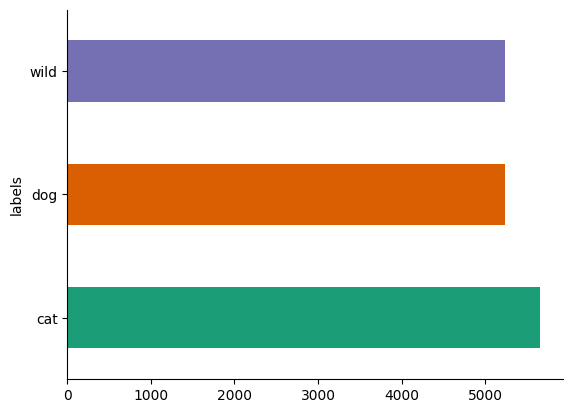

In [ ]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
data_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Первичный анализ данных

Выведем статистики вещественных признаков

In [ ]:
data_df.describe()

,image_path,labels
count,16130,16130
unique,16130,3
top,/kaggle/input/animal-faces/afhq/train/cat/pixa...,cat
freq,1,5653


Вывод: количество изображений 16130, как в image_path, так и в labels, а это показывает на отсутствуие пропусков в datasets. Уникальных значений 3. Больше всего изображений с котом. Частота 5653 изображения.

In [ ]:
data_df.shape

(16130, 2)

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  16130 non-null  object
 1   labels      16130 non-null  object
dtypes: object(2)
memory usage: 252.2+ KB


In [ ]:
data_df["labels"].value_counts().head()

,count
labels,
cat,5653
dog,5239
wild,5238


Разделим данные на train и test выборку

In [ ]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


Предварительная обработка

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

Custom Dataset Class

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

Dataset Objects

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

Визуализируем примеры для обучения

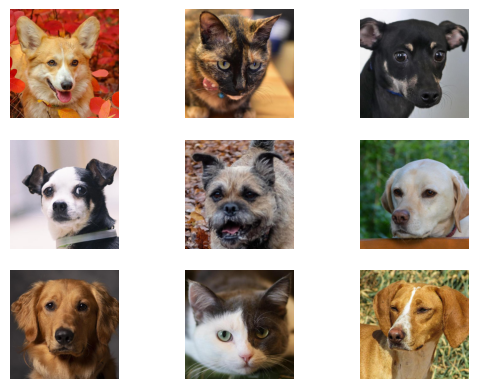

In [ ]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

# CNN

Гиперпараметры

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

DataLoaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
dataiter = iter(train_loader)
data = next(dataiter)
features, labels = data

In [ ]:
print('Размер изображения', features[0].shape)

Размер изображения torch.Size([3, 128, 128])


In [ ]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 3


CNN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 16 * 16, 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

model = Net().to(device)

Model Summary (Optional)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

Loss and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

Training Loop

In [ ]:
total_acc_train_plot, total_loss_train_plot = [], []
total_acc_validation_plot, total_loss_validation_plot = [], []

for epoch in range(EPOCHS):
    total_loss_train, total_acc_train = 0, 0
    model.train()

    for train_data in train_loader:
        inputs, labels = train_data
        outputs = model(inputs)
        batch_loss = loss_fn(outputs, labels)
        total_loss_train += batch_loss.item()
        total_acc_train += (outputs.argmax(1) == labels).sum().item()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()


    total_loss_train_plot.append(total_loss_train / len(train_loader))
    total_acc_train_plot.append(total_acc_train / len(train_dataset))

    total_loss_val, total_acc_val = 0, 0
    model.eval()
    with torch.inference_mode():
        for val_data in val_loader:
            inputs, labels = val_data
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, labels)
            total_loss_val += batch_loss.item()
            total_acc_val += (outputs.argmax(1) == labels).sum().item()

    total_loss_validation_plot.append(total_loss_val / len(val_loader))
    total_acc_validation_plot.append(total_acc_val / len(val_dataset))

    print(f"Epoch {epoch+1}: Train Loss={total_loss_train:.3f}, Acc={100*total_acc_train/len(train_dataset):.2f}%, "
          f"Val Loss={total_loss_val:.3f}, Acc={100*total_acc_val/len(val_dataset):.2f}%")

Epoch 1: Train Loss=338.613, Acc=80.21%, Val Loss=35.483, Acc=90.58%
Epoch 2: Train Loss=139.425, Acc=92.76%, Val Loss=29.389, Acc=92.44%
Epoch 3: Train Loss=96.011, Acc=95.30%, Val Loss=20.057, Acc=95.00%
Epoch 4: Train Loss=72.103, Acc=96.32%, Val Loss=18.179, Acc=95.33%
Epoch 5: Train Loss=54.282, Acc=97.27%, Val Loss=19.334, Acc=95.17%
Epoch 6: Train Loss=44.686, Acc=97.78%, Val Loss=24.929, Acc=94.17%
Epoch 7: Train Loss=27.908, Acc=98.63%, Val Loss=22.180, Acc=95.25%
Epoch 8: Train Loss=21.964, Acc=98.89%, Val Loss=18.216, Acc=96.49%
Epoch 9: Train Loss=14.773, Acc=99.33%, Val Loss=18.453, Acc=96.07%
Epoch 10: Train Loss=16.370, Acc=99.26%, Val Loss=24.359, Acc=95.45%


Тестирование

In [ ]:
with torch.inference_mode():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = loss_fn(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.2381 and Loss is 0.0205


Plot Training Progress

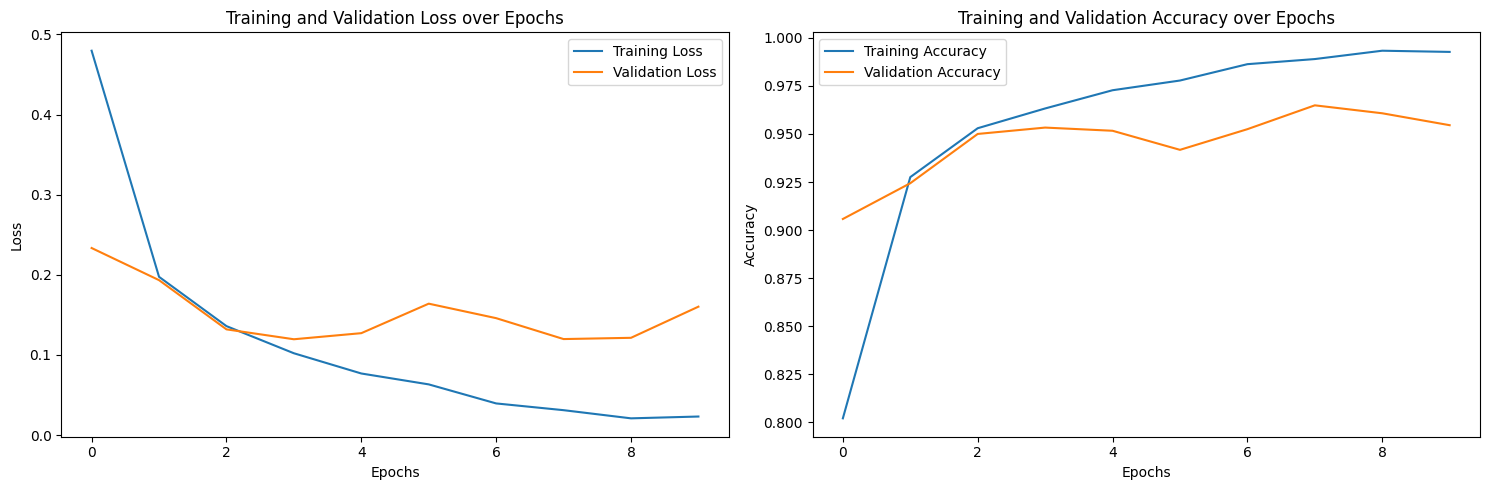

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

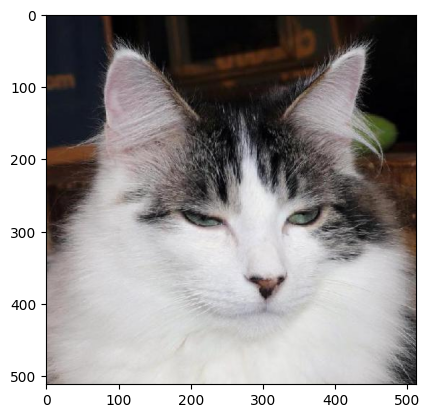


Prediction: 



array(['cat'], dtype=object)

In [ ]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000029.jpg")
plt.imshow(image)
plt.show()

## Predict
print()
print("Prediction: \n")
predict_image("/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000029.jpg")

Сохраняем модель

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

torch.save(model.state_dict(),"model.pt")

# loaded_model = CNN()
# loaded_model.load_state_dict(torch.load("model.pt"))

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
linear.weight 	 torch.Size([128, 32768])
linear.bias 	 torch.Size([128])
output.weight 	 torch.Size([3, 128])
output.bias 	 torch.Size([3])


Вывод: Сверточная модель хорошо справляется с классификацией изображений. Почти стопроцентная точность на обучающей выборке достигается за малое количество эпох. Однако, модель всё же допускает ошибки. Подобных ошибок модель совершает около 4%. Однозначно, можно улучшить результаты. Попробуем fine-tuning!

# VGG19

In [ ]:
from torchvision import models
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg19.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace=True)
    (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (26): ReLU(inplace=True)
    (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): ReLU(inplace=True)
    (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (33): ReLU(inplace=True)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): ReLU(inplace=True)
    (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)>

Обрезаем последний слой

In [ ]:
vgg19.classifier = nn.Sequential(*list(vgg19.classifier.children()))[:-1]

Добавляем новый слой

In [ ]:
class New_VGG19(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg19 = vgg19
        for param in self.vgg19.features.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(4096, 3)

    def forward(self, x):
        x = self.vgg19(x)
        x = self.fc(x)
        F.log_softmax(x,dim=1)
        return x

Выполняем очистку

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

25962

Дообучаем сеть

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
EPOCH_NUMBER = 1
TRAIN_LOSS = []
TRAIN_ACCURACY = []

start_time = time.time()
model = New_VGG19().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

for epoch in range(1,EPOCH_NUMBER+1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for data_,target_ in tqdm(train_loader):
        target_ = target_.to(device)
        data_ = data_.to(device)

        optimizer.zero_grad()

        outputs = model(data_)
        loss = criterion(outputs,target_)

        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct = correct + torch.sum(pred == target_).item()
        total += target_.size(0)

    c_time = int(time.time() - start_time)
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch:.4f}: Accuracy: {100 * correct/total:.4f}, Loss: {epoch_loss}, Time: {c_time}")

  0%|          | 0/706 [00:00<?, ?it/s]

Epoch 1.0000: Accuracy: 97.8390, Loss: 77.22385608128707, Time: 90


In [ ]:
with torch.inference_mode():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = loss_fn(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 97.6023 and Loss is 0.0208


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

# densenet161

In [ ]:
densenet161 = models.densenet161(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
densenet161.parameters

<bound method Module.parameters of DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer4): _DenseLayer(
        (norm1): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(240, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer5): _DenseLayer(
        (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(288, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer6): _DenseLayer(
        (norm1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(336, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Transition(
      (norm): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (denseblock2): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
densenet161.classifier = nn.Sequential(*list(densenet161.classifier.children()))[:-1]

In [ ]:
class New_densenet161(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet161 = New_densenet161
        for param in self.New_densenet161.features.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(4096, 3)

    def forward(self, x):
        x = self.New_densenet161(x)
        x = self.fc(x)
        F.log_softmax(x,dim=1)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

8

In [ ]:
EPOCH_NUMBER = 1
TRAIN_LOSS = []
TRAIN_ACCURACY = []

start_time = time.time()
model = New_densenet161().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

for epoch in range(1,EPOCH_NUMBER+1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for data_,target_ in tqdm(train_loader):
        target_ = target_.to(device)
        data_ = data_.to(device)

        optimizer.zero_grad()

        outputs = model(data_)
        loss = criterion(outputs,target_)

        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct = correct + torch.sum(pred == target_).item()
        total += target_.size(0)

    c_time = int(time.time() - start_time)
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch:.4f}: Accuracy: {100 * correct/total:.4f}, Loss: {epoch_loss}, Time: {c_time}")

AttributeError: 'New_densenet161' object has no attribute 'New_densenet161'